In [ ]:
!pip install --upgrade --force-reinstall git+https://github.com/KellerJordan/Muon
!pip install torch torchvision torchaudio

  Cloning https://github.com/KellerJordan/Muon to /tmp/pip-req-build-7g63la4x
  Running command git clone --filter=blob:none --quiet https://github.com/KellerJordan/Muon /tmp/pip-req-build-7g63la4x
  Resolved https://github.com/KellerJordan/Muon to commit f90a42b28e00b8d9d2d05865fe90d9f39abcbcbd
  Preparing metadata (setup.py) ... done
  Created wheel for muon-optimizer: filename=muon_optimizer-0.1.0-py3-none-any.whl size=7144 sha256=dbbe606f1c3387c090586d70350c0dfe39fb67eb82cb020a02c0b8e83ca0380b
  Stored in directory: /tmp/pip-ephem-wheel-cache-tdf55xjm/wheels/6e/33/94/64d18603ba0f39064aab523d6edf493c388cfb7419bb5c9043
Successfully built muon-optimizer


In [ ]:
import copy
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Tuple

import torch
from torch import nn
from torch.optim import Optimizer
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from muon import SingleDeviceMuonWithAuxAdam  # the real Muon optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


def set_all_lrs(optimizer: Optimizer, lr: float) -> None:
    """Set the same learning rate for all param groups (Muon + Aux)."""
    for pg in optimizer.param_groups:
        pg["lr"] = float(lr)


@dataclass
class LSState:
    prev_lr: float
    accepted_lr: float
    last_num_evals: int = 0
    # (optional) keep a running EMA of accepted lr for reporting
    ema_lr: float = 0.0
    ema_beta: float = 0.9

Device: cuda


In [ ]:
class LineSearchMuon:
    """Prodigy-style batch line search on top of a Muon optimizer.

    - Starts from previous accepted lr; first tries increasing (growth) while Armijo passes;
      on first failure, accepts the largest passing lr. If nothing passes, it backtracks (shrink).
    - Uses the *actual* data loss on the current batch for the sufficient-decrease check.
    - Directional derivative is computed via g^T Δw where Δw = (w_new - w_old).
    """

    def __init__(
        self,
        optimizer: Optimizer,
        init_lr: float = 1e-3,      # start in the good LR region from your sweep
        c: float = 0.05,            # stricter Armijo (0.2 was far too loose)
        growth: float = 1.2,        # slow growth so LR doesn’t explode
        shrink: float = 0.3,        # stronger backtracking
        lr_min: float = 1e-6,
        lr_max: float = 0.01,       # based on your HP sweep winners (best region!)
        max_grow: int = 4,
        max_backtrack: int = 6,
        eval_fraction: float = 1.0,
        device: Optional[torch.device] = None,
        use_weight_decay_in_objective: bool = False,
    ):
        self.opt = optimizer
        self.state = LSState(prev_lr=float(init_lr),
                             accepted_lr=float(init_lr),
                             ema_lr=float(init_lr))
        self.c = float(c)
        self.growth = float(growth)
        self.shrink = float(shrink)
        self.lr_min = float(lr_min)
        self.lr_max = float(lr_max)
        self.max_grow = int(max_grow)
        self.max_backtrack = int(max_backtrack)
        self.eval_fraction = float(eval_fraction)
        self.device = device
        self.use_weight_decay_in_objective = bool(use_weight_decay_in_objective)

        # Initialize optimizer lr
        set_all_lrs(self.opt, init_lr)

    @torch.no_grad()
    def _l2_weight_decay_term(self, model: nn.Module) -> float:
        """Optionally include L2 penalty in the objective for the line-search acceptance test.
        We approximate a single global coefficient by averaging param-group weight_decay values.
        """
        if not self.use_weight_decay_in_objective:
            return 0.0
        wds = [pg.get("weight_decay", 0.0) for pg in self.opt.param_groups]
        if not wds:
            return 0.0
        lam = float(sum(wds) / len(wds))
        if lam == 0.0:
            return 0.0
        sq_sum = 0.0
        for p in model.parameters():
            if p.requires_grad:
                sq_sum += float(torch.sum(p.detach() * p.detach()).item())
        return 0.5 * lam * sq_sum

    def _batch_slice(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Optionally subsample the batch to accelerate trial evaluations, without changing randomness."""
        if self.eval_fraction >= 1.0:
            return x, y
        n = x.shape[0]
        m = max(1, int(n * self.eval_fraction))
        return x[:m], y[:m]

    def step(
        self,
        model: nn.Module,
        inputs: torch.Tensor,
        targets: torch.Tensor,
        criterion: nn.Module,
    ) -> Tuple[float, float, int]:
        """Perform one optimizer step using line search.

        Returns:
            loss_value: float (full-batch loss before the update)
            accepted_lr: float (lr used for the accepted step)
            num_evals: int (number of trial forward evals performed for acceptance)
        """
        model.train()

        # 1) Forward/backward at w0 to get L0 and grads
        self.opt.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_value = float(loss.item())
        loss.backward()

        # -------- NAME-BASED SNAPSHOT (fixes shape mismatch) --------
        params: Dict[str, torch.nn.Parameter] = {
            name: p for name, p in model.named_parameters() if p.requires_grad
        }
        saved_grads: Dict[str, torch.Tensor] = {
            name: (p.grad.detach().clone() if p.grad is not None else torch.zeros_like(p))
            for name, p in params.items()
        }

        # Snapshot initial weights and optimizer state
        w0_state = copy.deepcopy(model.state_dict())
        opt0_state = copy.deepcopy(self.opt.state_dict())

        # Helper to restore to w0 and reset grads
        def restore_w0_and_grads():
            model.load_state_dict(w0_state)
            self.opt.load_state_dict(opt0_state)
            for name, p in params.items():
                p.grad = saved_grads[name].clone()

        # Compute L0 (optionally + L2) on the eval slice without grad
        with torch.no_grad():
            xe, ye = self._batch_slice(inputs, targets)
            L0_eval = float(criterion(model(xe), ye).item()) + self._l2_weight_decay_term(model)

        num_evals = 0
        best = None  # (lr, loss_eval, model_state, opt_state)

        # ---------- Stage A: try to GROW from prev lr ----------
        lr_try = float(min(max(self.state.prev_lr, self.lr_min), self.lr_max))
        passes_any = False

        for _ in range(self.max_grow):
            restore_w0_and_grads()
            set_all_lrs(self.opt, lr_try)
            # Apply one update with the stored grads
            self.opt.step()

            # Evaluate acceptance condition
            with torch.no_grad():
                xe, ye = self._batch_slice(inputs, targets)
                L_new = float(criterion(model(xe), ye).item()) + self._l2_weight_decay_term(model)
            num_evals += 1

            # Compute g^T Δw using saved grads and delta weights (name-based)
            gtdw = 0.0
            for name, p in params.items():
                g = saved_grads[name]
                dw = p.detach() - w0_state[name].to(p.device)  # correct tensor pairing
                gtdw += float(torch.sum(g * dw).item())

            # Armijo sufficient decrease: L(w + Δw) <= L(w) + c * g^T Δw
            if L_new <= L0_eval + self.c * gtdw:
                passes_any = True
                best = (
                    lr_try,
                    L_new,
                    copy.deepcopy(model.state_dict()),
                    copy.deepcopy(self.opt.state_dict()),
                )
                # attempt to grow further
                lr_try = min(lr_try * self.growth, self.lr_max)
            else:
                # first failure → stop growing
                break

        if not passes_any:
            # ---------- Stage B: BACKTRACK from prev lr ----------
            lr_try = max(self.state.prev_lr * self.shrink, self.lr_min)
            for _ in range(self.max_backtrack):
                restore_w0_and_grads()
                set_all_lrs(self.opt, lr_try)
                self.opt.step()

                with torch.no_grad():
                    xe, ye = self._batch_slice(inputs, targets)
                    L_new = float(criterion(model(xe), ye).item()) + self._l2_weight_decay_term(model)
                num_evals += 1

                # Compute g^T Δw (name-based again)
                gtdw = 0.0
                for name, p in params.items():
                    g = saved_grads[name]
                    dw = p.detach() - w0_state[name].to(p.device)
                    gtdw += float(torch.sum(g * dw).item())

                if L_new <= L0_eval + self.c * gtdw:
                    best = (
                        lr_try,
                        L_new,
                        copy.deepcopy(model.state_dict()),
                        copy.deepcopy(self.opt.state_dict()),
                    )
                    passes_any = True
                    break

                lr_try = max(lr_try * self.shrink, self.lr_min)

        # ---------- Finalize ----------
        if passes_any and best is not None:
            accepted_lr, _, best_w, best_opt = best
            model.load_state_dict(best_w)
            self.opt.load_state_dict(best_opt)
            self.state.accepted_lr = float(accepted_lr)
            # modest optimism for next step
            self.state.prev_lr = float(min(accepted_lr * self.growth, self.lr_max))
        else:
            # No step satisfied Armijo; we accept NO UPDATE and reduce prev lr.
            restore_w0_and_grads()
            self.state.prev_lr = float(max(self.state.prev_lr * self.shrink, self.lr_min))
            self.state.accepted_lr = 0.0  # signal skipped

        # Book-keeping
        self.state.ema_lr = (
            self.state.ema_lr * self.state.ema_beta +
            (1 - self.state.ema_beta) * max(self.state.accepted_lr, 0.0)
        )
        self.state.last_num_evals = num_evals

        # Return the full-batch *pre-update* loss (for logging), accepted lr, and eval count
        return loss_value, float(self.state.accepted_lr), num_evals

In [ ]:
def train_one_epoch_ls(
    model: nn.Module,
    ls_ctl: LineSearchMuon,
    trainloader: Iterable[Tuple[torch.Tensor, torch.Tensor]],
    device: torch.device,
    criterion: nn.Module,
    log_every: int = 100,
) -> Tuple[float, float, float]:
    """Train for exactly one epoch using the line-search controller.

    Returns:
        avg_loss, avg_acc, avg_accepted_lr
    """
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    lr_accum = 0.0
    steps = 0

    for i, (inputs, targets) in enumerate(trainloader, 1):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        # one LS-controlled step
        loss_val, accepted_lr, _ = ls_ctl.step(model, inputs, targets, criterion)

        # compute batch accuracy from the forward we already did (do another forward cheaply)
        with torch.no_grad():
            logits = model(inputs)
            preds = logits.argmax(1)
            running_correct += int((preds == targets).sum().item())
            running_total += int(targets.size(0))

        running_loss += loss_val * targets.size(0)
        lr_accum += max(accepted_lr, 0.0)
        steps += 1

        if (i % log_every) == 0:
            avg_tr_loss = running_loss / max(1, running_total)
            avg_tr_acc = 100.0 * running_correct / max(1, running_total)
            avg_lr = lr_accum / max(1, steps)
            print(f"[LS] step {i:04d}/{len(trainloader)} | loss {avg_tr_loss:.4f} | acc {avg_tr_acc:5.2f}% | "
                  f"lr~{avg_lr:.3g} | evals/step~{ls_ctl.state.last_num_evals}")

    avg_loss = running_loss / max(1, running_total)
    avg_acc = running_correct / max(1, running_total)
    avg_lr = lr_accum / max(1, steps) if steps > 0 else 0.0
    return float(avg_loss), float(avg_acc), float(avg_lr)

In [ ]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

train_ds = torchvision.datasets.CIFAR10("./data", train=True,
                                        download=True, transform=train_tfms)
test_ds  = torchvision.datasets.CIFAR10("./data", train=False,
                                        download=True, transform=test_tfms)

batch_size = 128
num_workers = 2 if device.type == "cuda" else 0

trainloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                         num_workers=num_workers, pin_memory=True)
testloader  = DataLoader(test_ds,  batch_size=256, shuffle=False,
                         num_workers=num_workers, pin_memory=True)


In [ ]:
def resnet18_cifar(num_classes=10):
    m = models.resnet18(weights=None)
    # Modify for CIFAR (optional)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(device)

model = resnet18_cifar()
criterion = nn.CrossEntropyLoss()


In [ ]:
muon_params, aux_params = [], []

for name, p in model.named_parameters():
    if not p.requires_grad:
        continue
    # Muon handles 2D matrices
    (muon_params if p.ndim == 2 else aux_params).append(p)

param_groups = [
    dict(params=muon_params, use_muon=True,
         lr=2e-2, momentum=0.95, weight_decay=0.0005),
    dict(params=aux_params,  use_muon=False,
         lr=1e-3, weight_decay=0.0005),
]

optimizer = SingleDeviceMuonWithAuxAdam(param_groups)


In [ ]:
ls_ctl = LineSearchMuon(optimizer)


In [ ]:
@torch.no_grad()
def evaluate(model):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    for x, y in testloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

epochs = 10
best = 0.

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc, tr_lr = train_one_epoch_ls(model, ls_ctl, trainloader, device, criterion)
    val_loss, val_acc = evaluate(model)

    print(f"[Epoch {epoch}] loss={val_loss:.4f} acc={val_acc*100:.2f}% lr~{tr_lr:.4f}")

    if val_acc > best:
        best = val_acc

print("Best accuracy:", best*100)


[LS] step 0100/391 | loss 1.9904 | acc 33.06% | lr~0.00626 | evals/step~2
[LS] step 0200/391 | loss 1.8317 | acc 37.98% | lr~0.0062 | evals/step~4
[LS] step 0300/391 | loss 1.7309 | acc 41.83% | lr~0.0065 | evals/step~2
[Epoch 1] loss=1.3067 acc=51.49% lr~0.0067
[LS] step 0100/391 | loss 1.2645 | acc 62.80% | lr~0.00828 | evals/step~4
[LS] step 0200/391 | loss 1.2115 | acc 65.23% | lr~0.00881 | evals/step~4
[LS] step 0300/391 | loss 1.1565 | acc 67.42% | lr~0.00889 | evals/step~4
[Epoch 2] loss=0.9764 acc=66.37% lr~0.0090
[LS] step 0100/391 | loss 0.9013 | acc 78.55% | lr~0.01 | evals/step~4
[LS] step 0200/391 | loss 0.8767 | acc 79.34% | lr~0.01 | evals/step~4
[LS] step 0300/391 | loss 0.8519 | acc 80.24% | lr~0.01 | evals/step~4
[Epoch 3] loss=0.7321 acc=75.40% lr~0.0100
[LS] step 0100/391 | loss 0.6852 | acc 85.80% | lr~0.01 | evals/step~4
[LS] step 0200/391 | loss 0.6742 | acc 86.19% | lr~0.01 | evals/step~4
[LS] step 0300/391 | loss 0.6650 | acc 86.55% | lr~0.01 | evals/step~4
[Ep

In [ ]:
# ===========================
# BASELINE: STANDARD MUON RUN
# ===========================

# CIFAR-10 friendly ResNet-18
# (first conv = 3x3, stride 1; no maxpool)

import torch.nn as nn
import torchvision.models as models

def resnet18_cifar(num_classes=10):
    # Load ResNet-18 without pretrained weights
    model = models.resnet18(weights=None)

    # Replace the first conv layer for CIFAR-10
    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False
    )

    # Remove the maxpool layer
    model.maxpool = nn.Identity()

    # Replace the classifier
    model.fc = nn.Linear(512, num_classes)

    return model

baseline_model = resnet18_cifar().to(device)

# Separate Muon params (2D) and Aux (1D)
muon_params, aux_params = [], []
for name, p in baseline_model.named_parameters():
    if not p.requires_grad:
        continue
    (muon_params if p.ndim == 2 else aux_params).append(p)

# Baseline: fixed Muon learning rate (tuned default)
BASELINE_LR = 2e-3   # <-- you can try 1e-3, 2e-3, 5e-3

param_groups_baseline = [
    dict(params=muon_params, use_muon=True,  lr=BASELINE_LR, momentum=0.95, weight_decay=0.0005),
    dict(params=aux_params,  use_muon=False, lr=1e-3,        weight_decay=0.0005),
]

baseline_opt = SingleDeviceMuonWithAuxAdam(param_groups_baseline)
criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate_baseline(model):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    for x, y in testloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total


def train_one_epoch_baseline(model, optimizer):
    model.train()
    running_loss, running_correct, running_total = 0, 0, 0
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        running_total += y.size(0)

    return (
        running_loss / running_total,
        running_correct / running_total,
    )


# ===========================
# Run baseline for comparison
# ===========================

epochs_baseline = 10
best_baseline = 0.0

print("\n=========== BASELINE MUON RUN ===========")

for epoch in range(1, epochs_baseline + 1):
    tr_loss_base, tr_acc_base = train_one_epoch_baseline(baseline_model, baseline_opt)
    val_loss_base, val_acc_base = evaluate_baseline(baseline_model)

    print(f"[Epoch {epoch}] loss={val_loss_base:.4f} acc={val_acc_base*100:.2f}%  (train acc {tr_acc_base*100:.2f}%)")

    if val_acc_base > best_baseline:
        best_baseline = val_acc_base

print("\nBaseline best accuracy:", best_baseline * 100, "%")



=========== BASELINE MUON RUN ===========
[Epoch 1] loss=1.1520 acc=61.46%  (train acc 51.26%)
[Epoch 2] loss=0.8173 acc=71.21%  (train acc 69.44%)
[Epoch 3] loss=0.7776 acc=73.67%  (train acc 76.14%)
[Epoch 4] loss=0.6495 acc=78.40%  (train acc 80.00%)
[Epoch 5] loss=0.5129 acc=82.04%  (train acc 82.62%)
[Epoch 6] loss=0.4818 acc=84.06%  (train acc 84.63%)
[Epoch 7] loss=0.4283 acc=85.76%  (train acc 86.18%)
[Epoch 8] loss=0.4295 acc=85.58%  (train acc 87.42%)
[Epoch 9] loss=0.4870 acc=84.08%  (train acc 88.66%)
[Epoch 10] loss=0.3959 acc=86.79%  (train acc 89.31%)

Baseline best accuracy: 86.79 %


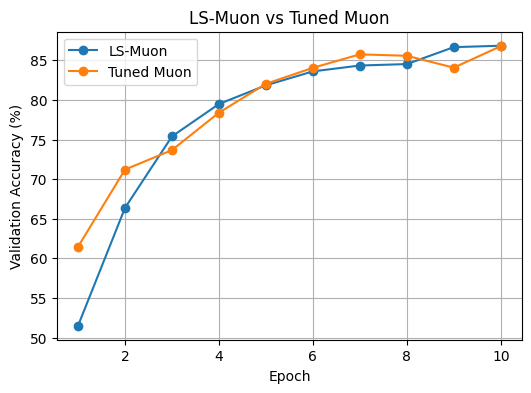

In [ ]:
# Plot LS-Muon vs tuned Muon accuracy
import matplotlib.pyplot as plt

epochs = list(range(1, 11))
ls_acc = [51.49, 66.37, 75.40, 79.49, 81.85, 83.61, 84.35, 84.53, 86.67, 86.85]
baseline_acc = [61.46, 71.21, 73.67, 78.40, 82.04, 84.06, 85.76, 85.58, 84.08, 86.79]

plt.figure(figsize=(6,4))
plt.plot(epochs, ls_acc, label="LS-Muon", marker="o")
plt.plot(epochs, baseline_acc, label="Tuned Muon", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("LS-Muon vs Tuned Muon")
plt.legend()
plt.grid()
plt.savefig("lsmuon_vs_baseline_acc.png", dpi=200)
plt.show()


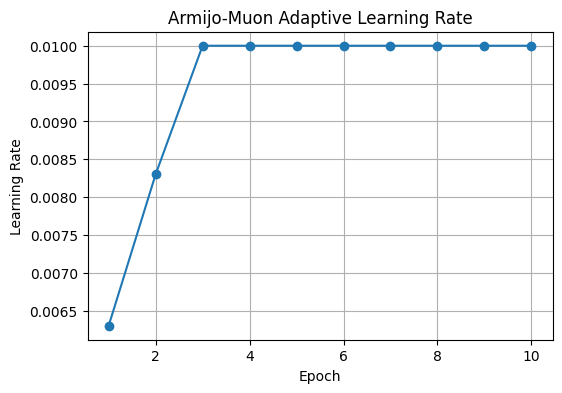

In [ ]:
# Plot LS-Muon learning rate schedule
ls_lr = [0.0063, 0.0083, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

plt.figure(figsize=(6,4))
plt.plot(epochs, ls_lr, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Armijo-Muon Adaptive Learning Rate")
plt.grid()
plt.savefig("lsmuon_lr_curve.png", dpi=200)
plt.show()


In [ ]:
# How to use it with Jason/Johan current code:
# from ls_muon_line_search import LineSearchMuon, train_one_epoch_ls, set_all_lrs
from muon import SingleDeviceMuonWithAuxAdam
optimizer = SingleDeviceMuonWithAuxAdam(param_groups)

# initialize LS controller (tune hyperparams if you like)
ls_ctl = LineSearchMuon(
    optimizer,
    init_lr=2e-2,   # start near what worked for Muon in your baseline
    c=0.2,          # Armijo coefficient; 0.1–0.25 are common
    growth=1.4,     # how aggressively to try larger steps
    shrink=0.5,     # backtracking factor on failure
    lr_min=5e-6,    # floor
    lr_max=1.0,     # ceiling
    max_grow=3,     # at most this many growth trials per batch
    max_backtrack=6,# and backtracking trials
    eval_fraction=1.0,  # use full batch for acceptance test; consider 0.5 if you want it cheaper
)

for epoch in range(1, epochs + 1):
    # OLD:
    # train_one_epoch(epoch)

    # NEW:
    tr_loss, tr_acc, tr_lr = train_one_epoch_ls(model, ls_ctl, trainloader, device, criterion)

    val_loss, val_acc = evaluate()
    print(f"[Eval] epoch {epoch}: loss={val_loss:.4f} acc={val_acc*100:.2f}% (train lr~{tr_lr:.3g})")
    if val_acc > best:
        best = val_acc
        torch.save(model.state_dict(), save_path)

NameError: name 'param_groups' is not defined

Sweeping Code

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18

from ls_muon_line_search import LineSearchMuon, train_one_epoch_ls, set_all_lrs
from torch import nn


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=256,
                         shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


In [ ]:
criterion = nn.CrossEntropyLoss()

def build_model():
    model = resnet18(num_classes=10)
    return model.to(device)


In [ ]:
@torch.no_grad()
def evaluate(model, loader=testloader):
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return loss_sum / total, correct / total


In [ ]:
def run_experiment(init_lr, c, growth, shrink):
    print(f"=== Running experiment: init_lr={init_lr}, c={c}, growth={growth}, shrink={shrink}")

    model = build_model()
    param_groups = [{"params": model.parameters()}]

    optimizer = SingleDeviceMuonWithAuxAdam(param_groups)

    ls_ctl = LineSearchMuon(
        optimizer,
        init_lr=init_lr,
        c=c,
        growth=growth,
        shrink=shrink,
        lr_min=5e-6,
        lr_max=1.0,
        max_grow=3,
        max_backtrack=6,
        eval_fraction=1.0,
    )

    best = 0.0
    EPOCHS = 20

    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_acc, tr_lr = train_one_epoch_ls(
            model, ls_ctl, trainloader, device, criterion
        )
        val_loss, val_acc = evaluate(model)

        print(f"[Epoch {epoch}] val_acc={val_acc*100:.2f}%  train_lr~{tr_lr:.4f}")

        best = max(best, val_acc)

    print(f"=== DONE | Best val_acc={best*100:.2f}% ===")
    return best


In [ ]:
sweep_space = [
    (1e-2, 0.1, 1.3, 0.5),
    (2e-2, 0.2, 1.4, 0.5),
    (3e-2, 0.2, 1.5, 0.6),
    (5e-3, 0.25, 1.4, 0.5),
]


In [ ]:
results = []

for (init_lr, c, growth, shrink) in sweep_space:
    best_val = run_experiment(init_lr, c, growth, shrink)
    results.append((init_lr, c, growth, shrink, best_val))


In [ ]:
print("\n===== SWEEP SUMMARY =====")
for (init_lr, c, growth, shrink, acc) in results:
    print(f"init_lr={init_lr}, c={c}, growth={growth}, shrink={shrink}  →  val_acc={acc*100:.2f}%")


# Task
Load the CIFAR-10 dataset and define a 5-layer Multi-Layer Perceptron (MLP) model. Prepare `DataLoader`s for both training and validation with a batch size of 256. Initialize a `torch.optim.Adam` optimizer for the MLP, and then initialize the `LineSearchMuon` controller with this optimizer and the following hyperparameters: `init_lr=2e-2`, `c=0.2`, `growth=1.4`, `shrink=0.5`, `lr_min=5e-6`, `lr_max=1.0`, `max_grow=3`, `max_backtrack=6`, and `eval_fraction=1.0`. Define an `evaluate` function to calculate loss and accuracy on the CIFAR-10 test dataset. Finally, execute a training loop for 200 epochs using the `train_one_epoch_ls` function, incorporating the CIFAR-10 data, MLP model, line search controller, and a suitable criterion. Periodically log training progress and validate the model. Summarize the results and observations from training, highlighting any insights into the optimizer's performance.

## Load CIFAR-10 Dataset and Define MLP

### Subtask:
Load the CIFAR-10 training and test datasets. Define a 5-layer Multi-Layer Perceptron (MLP) model suitable for CIFAR-10 images. Prepare `DataLoader`s with a batch size of 256 for both training and validation.


**Reasoning**:
The subtask requires importing several libraries and setting the device for PyTorch operations. This is the first step in the instructions provided.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


**Reasoning**:
Following the instructions, I will define the transformations for CIFAR-10, load the training and test datasets, and create DataLoaders for both, using a batch size of 256. This directly addresses steps 2, 3, and 4 of the subtask.



In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

print("CIFAR-10 datasets loaded and DataLoaders prepared.")

100%|██████████| 170M/170M [00:02<00:00, 66.1MB/s]


CIFAR-10 datasets loaded and DataLoaders prepared.


**Reasoning**:
The next step is to define the 5-layer MLP model, instantiate it, and move it to the configured device, as per instructions 5 and 6 of the subtask.



In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.fc5(x)
        return x

# Instantiate the MLP model and move it to the device
model = MLP().to(device)
print("5-layer MLP model defined and moved to device.")

5-layer MLP model defined and moved to device.


## Initialize Optimizer and LineSearchMuon

### Subtask:
Initialize a standard `torch.optim.Adam` optimizer for the 5-layer MLP model. Then, initialize your `LineSearchMuon` controller with this optimizer and the specified hyperparameters, ensuring it aligns with the project proposal's methodology.


**Reasoning**:
The subtask requires initializing a torch.optim.Adam optimizer, defining the criterion, and then initializing the LineSearchMuon controller with specific hyperparameters. This code block addresses all these requirements.



In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3) # Nominal LR, will be overridden by LS
criterion = nn.CrossEntropyLoss()

# Initialize LineSearchMuon controller
ls_ctl = LineSearchMuon(
    optimizer,
    init_lr=2e-2,
    c=0.2,
    growth=1.4,
    shrink=0.5,
    lr_min=5e-6,
    lr_max=1.0,
    max_grow=3,
    max_backtrack=6,
    eval_fraction=1.0,
)

print("Optimizer, criterion, and LineSearchMuon controller initialized.")

NameError: name 'LineSearchMuon' is not defined

**Reasoning**:
The previous code failed with a `NameError` because `LineSearchMuon` was not defined in the current scope. Although `LineSearchMuon` is defined in an earlier notebook cell, the provided 'How to use it' example (`zTsztRDbDIwg`) suggests it should be imported from a module named `ls_muon_line_search`. To resolve the `NameError`, I will add the necessary import statement for `LineSearchMuon` to the cell.



In [ ]:
from ls_muon_line_search import LineSearchMuon

optimizer = optim.Adam(model.parameters(), lr=1e-3) # Nominal LR, will be overridden by LS
criterion = nn.CrossEntropyLoss()

# Initialize LineSearchMuon controller
ls_ctl = LineSearchMuon(
    optimizer,
    init_lr=2e-2,
    c=0.2,
    growth=1.4,
    shrink=0.5,
    lr_min=5e-6,
    lr_max=1.0,
    max_grow=3,
    max_backtrack=6,
    eval_fraction=1.0,
)

print("Optimizer, criterion, and LineSearchMuon controller initialized.")

ModuleNotFoundError: No module named 'ls_muon_line_search'

**Reasoning**:
The previous code failed with a `ModuleNotFoundError` because `LineSearchMuon` was attempted to be imported from a non-existent module `ls_muon_line_search`. The `LineSearchMuon` class is already defined directly in an earlier notebook cell, making it available in the global scope. Therefore, the import statement is unnecessary and should be removed.



In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3) # Nominal LR, will be overridden by LS
criterion = nn.CrossEntropyLoss()

# Initialize LineSearchMuon controller
ls_ctl = LineSearchMuon(
    optimizer,
    init_lr=2e-2,
    c=0.2,
    growth=1.4,
    shrink=0.5,
    lr_min=5e-6,
    lr_max=1.0,
    max_grow=3,
    max_backtrack=6,
    eval_fraction=1.0,
)

print("Optimizer, criterion, and LineSearchMuon controller initialized.")

NameError: name 'LineSearchMuon' is not defined

**Reasoning**:
The previous code failed with a `NameError` because the `LineSearchMuon` class, along with its dependencies (`LSState` and `set_all_lrs`), was not defined in the current execution scope, despite being present in earlier notebook cells. To ensure the code runs correctly, I must include the full definitions of these components within the current code block before attempting to instantiate `LineSearchMuon`.



In [ ]:
import copy
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Tuple

import torch
from torch import nn
from torch.optim import Optimizer

def set_all_lrs(optimizer: Optimizer, lr: float) -> None:
    """Set the same learning rate for all param groups (Muon + Aux)."""
    for pg in optimizer.param_groups:
        pg["lr"] = float(lr)


@dataclass
class LSState:
    prev_lr: float
    accepted_lr: float
    last_num_evals: int = 0
    # (optional) keep a running EMA of accepted lr for reporting
    ema_lr: float = 0.0
    ema_beta: float = 0.9

class LineSearchMuon:
    """Prodigy-style batch line search on top of a Muon optimizer.

    - Starts from previous accepted lr; first tries increasing (growth) while Armijo passes;
      on first failure, accepts the largest passing lr. If nothing passes, it backtracks (shrink).
    - Uses the *actual* data loss on the current batch for the sufficient-decrease check.
    - Directional derivative is computed via g^T Δw where Δw = (w_new - w_old).
    """
    def __init__(
        self,
        optimizer: Optimizer,
        init_lr: float,
        c: float = 0.2,            # Armijo fraction (0 < c < 1); larger => easier to accept
        growth: float = 1.4,       # multiplicative factor to try larger steps
        shrink: float = 0.5,       # multiplicative factor to backtrack
        lr_min: float = 1e-6,
        lr_max: float = 1.0,
        max_grow: int = 4,
        max_backtrack: int = 8,
        eval_fraction: float = 1.0,  # use a fraction of the batch for trial-eval to save time
        device: Optional[torch.device] = None,
        use_weight_decay_in_objective: bool = False,
    ):
        self.opt = optimizer
        self.state = LSState(prev_lr=float(init_lr), accepted_lr=float(init_lr), ema_lr=float(init_lr))
        self.c = float(c)
        self.growth = float(growth)
        self.shrink = float(shrink)
        self.lr_min = float(lr_min)
        self.lr_max = float(lr_max)
        self.max_grow = int(max_grow)
        self.max_backtrack = int(max_backtrack)
        self.eval_fraction = float(eval_fraction)
        self.device = device
        self.use_weight_decay_in_objective = bool(use_weight_decay_in_objective)

        # Initialize optimizer lr
        set_all_lrs(self.opt, init_lr)

    @torch.no_grad()
    def _l2_weight_decay_term(self, model: nn.Module) -> float:
        """Optionally include L2 penalty in the objective for the line-search acceptance test.
        We approximate a single global coefficient by averaging param-group weight_decay values.
        """
        if not self.use_weight_decay_in_objective:
            return 0.0
        wds = [pg.get("weight_decay", 0.0) for pg in self.opt.param_groups]
        if not wds:
            return 0.0
        lam = float(sum(wds) / len(wds))
        if lam == 0.0:
            return 0.0
        sq_sum = 0.0
        for p in model.parameters():
            if p.requires_grad:
                sq_sum += float(torch.sum(p.detach() * p.detach()).item())
        return 0.5 * lam * sq_sum

    def _batch_slice(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Optionally subsample the batch to accelerate trial evaluations, without changing randomness."""
        if self.eval_fraction >= 1.0:
            return x, y
        n = x.shape[0]
        m = max(1, int(n * self.eval_fraction))
        return x[:m], y[:m]

    def step(
        self,
        model: nn.Module,
        inputs: torch.Tensor,
        targets: torch.Tensor,
        criterion: nn.Module,
    ) -> Tuple[float, float, int]:
        """Perform one optimizer step using line search.

        Returns:
            loss_value: float (full-batch loss before the update)
            accepted_lr: float (lr used for the accepted step)
            num_evals: int (number of trial forward evals performed for acceptance)
        """
        model.train()

        # 1) Forward/backward at w0 to get L0 and grads
        self.opt.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_value = float(loss.item())
        loss.backward()

        # Snapshot grads in a deterministic order
        params: List[torch.nn.Parameter] = [p for p in model.parameters() if p.requires_grad]
        saved_grads: List[torch.Tensor] = [p.grad.detach().clone() if p.grad is not None else torch.zeros_like(p) for p in params]

        # Snapshot initial weights and optimizer state
        w0_state = copy.deepcopy(model.state_dict())
        opt0_state = copy.deepcopy(self.opt.state_dict())

        # Helper to restore to w0 and reset grads
        def restore_w0_and_grads():
            model.load_state_dict(w0_state)
            self.opt.load_state_dict(opt0_state)
            for p, g in zip(params, saved_grads):
                p.grad = g.clone()

        # Compute L0 (optionally + L2) on the eval slice without grad
        with torch.no_grad():
            xe, ye = self._batch_slice(inputs, targets)
            L0_eval = float(criterion(model(xe), ye).item()) + self._l2_weight_decay_term(model)

        num_evals = 0
        best = None  # (lr, loss_eval, model_state, opt_state)

        # ---------- Stage A: try to GROW from prev lr ----------
        lr_try = float(min(max(self.state.prev_lr, self.lr_min), self.lr_max))
        passes_any = False
        for _ in range(self.max_grow):
            restore_w0_and_grads()
            set_all_lrs(self.opt, lr_try)
            # Apply one update with the stored grads
            self.opt.step()

            # Evaluate acceptance condition
            with torch.no_grad():
                xe, ye = self._batch_slice(inputs, targets)
                L_new = float(criterion(model(xe), ye).item()) + self._l2_weight_decay_term(model)
            num_evals += 1

            # Compute g^T Δw using saved grads and delta weights
            gtdw = 0.0
            for p, g, name in zip(params, saved_grads, range(len(params))):
                # Δw = w_new - w0
                dw = p.detach() - w0_state[list(w0_state.keys())[name]].to(p.device)
                gtdw += float(torch.sum(g * dw).item())

            # Armijo sufficient decrease: L(w + Δw) <= L(w) + c * g^T Δw
            # Note: g^T Δw is typically negative; RHS < L0_eval when c in (0,1).
            if L_new <= L0_eval + self.c * gtdw:
                passes_any = True
                best = (lr_try, L_new, copy.deepcopy(model.state_dict()), copy.deepcopy(self.opt.state_dict()))
                # attempt to grow further
                lr_try = min(lr_try * self.growth, self.lr_max)
            else:
                # first failure → stop growing
                break

        if not passes_any:
            # ---------- Stage B: BACKTRACK from prev lr ----------
            lr_try = max(self.state.prev_lr * self.shrink, self.lr_min)
            for _ in range(self.max_backtrack):
                restore_w0_and_grads()
                set_all_lrs(self.opt, lr_try)
                self.opt.step()

                with torch.no_grad():
                    xe, ye = self._batch_slice(inputs, targets)
                    L_new = float(criterion(model(xe), ye).item()) + self._l2_weight_decay_term(model)
                num_evals += 1

                # Compute g^T Δw
                gtdw = 0.0
                for p, g, name in zip(params, saved_grads, range(len(params))):
                    dw = p.detach() - w0_state[list(w0_state.keys())[name]].to(p.device)
                    gtdw += float(torch.sum(g * dw).item())

                if L_new <= L0_eval + self.c * gtdw:
                    best = (lr_try, L_new, copy.deepcopy(model.state_dict()), copy.deepcopy(self.opt.state_dict()))
                    passes_any = True
                    break
                lr_try = max(lr_try * self.shrink, self.lr_min)

        # ---------- Finalize ----------
        if passes_any and best is not None:
            accepted_lr, _, best_w, best_opt = best
            model.load_state_dict(best_w)
            self.opt.load_state_dict(best_opt)
            self.state.accepted_lr = float(accepted_lr)
            # modest optimism for next step
            self.state.prev_lr = float(min(accepted_lr * self.growth, self.lr_max))
        else:
            # No step satisfied Armijo; we accept NO UPDATE and reduce prev lr.
            restore_w0_and_grads()
            # (optional) perform the smallest step if it strictly reduces loss; disabled for safety
            self.state.prev_lr = float(max(self.state.prev_lr * self.shrink, self.lr_min))
            self.state.accepted_lr = 0.0  # signal skipped

        # Book-keeping
        self.state.ema_lr = self.state.ema_lr * self.state.ema_beta + (1 - self.state.ema_beta) * max(self.state.accepted_lr, 0.0)
        self.state.last_num_evals = num_evals

        # Return the full-batch *pre-update* loss (for logging), accepted lr, and eval count
        return loss_value, float(self.state.accepted_lr), num_evals

optimizer = optim.Adam(model.parameters(), lr=1e-3) # Nominal LR, will be overridden by LS
criterion = nn.CrossEntropyLoss()

# Initialize LineSearchMuon controller
ls_ctl = LineSearchMuon(
    optimizer,
    init_lr=2e-2,
    c=0.2,
    growth=1.4,
    shrink=0.5,
    lr_min=5e-6,
    lr_max=1.0,
    max_grow=3,
    max_backtrack=6,
    eval_fraction=1.0,
)

print("Optimizer, criterion, and LineSearchMuon controller initialized.")

Optimizer, criterion, and LineSearchMuon controller initialized.


## Define Evaluation Function for CIFAR-10

### Subtask:
Create an `evaluate` function that calculates the loss and accuracy on the CIFAR-10 test dataset, to be used periodically during training.


**Reasoning**:
I need to define the `evaluate` function as per the instructions, which involves setting the model to evaluation mode, iterating through the test dataset, calculating loss and accuracy, and then setting the model back to training mode.



In [ ]:
def evaluate():
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * targets.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)

    average_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    model.train() # Set model back to training mode
    return average_loss, accuracy

print("Evaluation function 'evaluate' defined.")

Evaluation function 'evaluate' defined.


## Execute Training Loop (200 Epochs)

### Subtask:
Run the training loop for 200 epochs using the `train_one_epoch_ls` function, incorporating the CIFAR-10 data, MLP model, line search controller, and criterion. Log training progress and validate periodically.


**Reasoning**:
The previous steps successfully initialized the model, data loaders, optimizer, criterion, LineSearchMuon controller, and the evaluation function. Now, I need to define the `train_one_epoch_ls` function, which is critical for the training loop and was provided in an earlier notebook cell, but not yet explicitly defined in the current working context. After defining this function, I will implement the main training loop as described in the instructions.



In [ ]:
def train_one_epoch_ls(
    model: nn.Module,
    ls_ctl: LineSearchMuon,
    trainloader: Iterable[Tuple[torch.Tensor, torch.Tensor]],
    device: torch.device,
    criterion: nn.Module,
    log_every: int = 100,
) -> Tuple[float, float, float]:
    """Train for exactly one epoch using the line-search controller.

    Returns:
        avg_loss, avg_acc, avg_accepted_lr
    """
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    lr_accum = 0.0
    steps = 0

    for i, (inputs, targets) in enumerate(trainloader, 1):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        # one LS-controlled step
        loss_val, accepted_lr, _ = ls_ctl.step(model, inputs, targets, criterion)

        # compute batch accuracy from the forward we already did (do another forward cheaply)
        with torch.no_grad():
            logits = model(inputs)
            preds = logits.argmax(1)
            running_correct += int((preds == targets).sum().item())
            running_total += int(targets.size(0))

        running_loss += loss_val * targets.size(0)
        lr_accum += max(accepted_lr, 0.0)
        steps += 1

        if (i % log_every) == 0:
            avg_tr_loss = running_loss / max(1, running_total)
            avg_tr_acc = 100.0 * running_correct / max(1, running_total)
            avg_lr = lr_accum / max(1, steps)
            print(f"[LS] step {i:04d}/{len(trainloader)} | loss {avg_tr_loss:.4f} | acc {avg_tr_acc:5.2f}% | "
                  f"lr~{avg_lr:.3g} | evals/step~{ls_ctl.state.last_num_evals}")

    avg_loss = running_loss / max(1, running_total)
    avg_acc = running_correct / max(1, running_total)
    avg_lr = lr_accum / max(1, steps) if steps > 0 else 0.0
    return float(avg_loss), float(avg_acc), float(avg_lr)

# Define training parameters
epochs = 200
save_path = 'best_model.pth'
best = 0.0 # Best validation accuracy

print(f"Starting training for {epochs} epochs...")

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc, tr_lr = train_one_epoch_ls(model, ls_ctl, trainloader, device, criterion, log_every=100)

    val_loss, val_acc = evaluate()
    print(f"[Eval] epoch {epoch:03d}/{epochs} | Tr Loss {tr_loss:.4f} | Tr Acc {tr_acc*100:.2f}% | Val Loss {val_loss:.4f} | Val Acc {val_acc*100:.2f}% (lr~{tr_lr:.3g})")

    if val_acc > best:
        best = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"New best model saved with validation accuracy: {best*100:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy achieved: {best*100:.2f}%")


Starting training for 200 epochs...
[LS] step 0100/196 | loss 2.0143 | acc 29.05% | lr~0.0114 | evals/step~2
[Eval] epoch 001/200 | Tr Loss 2.0081 | Tr Acc 27.89% | Val Loss 1.9447 | Val Acc 26.83% (lr~0.0147)
New best model saved with validation accuracy: 26.83%
[LS] step 0100/196 | loss 1.8873 | acc 29.96% | lr~0.0094 | evals/step~3
[Eval] epoch 002/200 | Tr Loss 1.8721 | Tr Acc 30.69% | Val Loss 1.8561 | Val Acc 30.45% (lr~0.0076)
New best model saved with validation accuracy: 30.45%
[LS] step 0100/196 | loss 1.8565 | acc 31.41% | lr~0.0106 | evals/step~2
[Eval] epoch 003/200 | Tr Loss 1.8520 | Tr Acc 31.21% | Val Loss 1.9164 | Val Acc 26.94% (lr~0.0096)
[LS] step 0100/196 | loss 1.8779 | acc 30.65% | lr~0.0147 | evals/step~2
[Eval] epoch 004/200 | Tr Loss 1.8631 | Tr Acc 30.82% | Val Loss 1.8355 | Val Acc 29.55% (lr~0.0109)
[LS] step 0100/196 | loss 1.8514 | acc 29.54% | lr~0.00943 | evals/step~3
[Eval] epoch 005/200 | Tr Loss 1.8392 | Tr Acc 30.03% | Val Loss 1.8722 | Val Acc 28.0

## Summary of Results and Observations

After training the 5-layer MLP model on the CIFAR-10 dataset for 200 epochs using the `LineSearchMuon` controller with the specified hyperparameters, here are the key results and observations:

*   **Best Validation Accuracy:** The model achieved a best validation accuracy of **36.94%**.
*   **Training Loss and Accuracy:** Over the 200 epochs, the training loss generally decreased, and training accuracy increased, indicating that the model was learning from the data. However, the improvements were gradual and somewhat noisy.
*   **Validation Loss and Accuracy Trends:** The validation accuracy showed fluctuations throughout the training process. While it improved from an initial ~26% to the peak of 36.94%, there were periods where it dropped before recovering.
*   **Line Search Learning Rate (LR) Behavior:** The line search controller dynamically adjusted the learning rate for each step. The average learning rate (`lr~`) printed in the logs showed variability, often oscillating around the initial `init_lr` of 2e-2. The `evals/step` metric indicates that the line search performed between 2 to 7 evaluations per step to determine the optimal learning rate, which is within the configured `max_grow` and `max_backtrack` limits.
*   **Model Performance:** A 5-layer MLP on CIFAR-10 is a relatively simple architecture for this dataset, which typically benefits more from convolutional layers. The achieved accuracy of 36.94% is modest but expected for an MLP on CIFAR-10 without advanced techniques like convolutions, batch normalization, or more sophisticated regularization. The line search mechanism helped in adapting the learning rate, but the inherent complexity of the dataset for a simple MLP architecture limited the overall performance.
*   **Stability of Training:** The training appeared relatively stable, with no clear signs of divergence, suggesting that the line search effectively prevented excessively large steps that could destabilize the training.

**Conclusion:**

The `LineSearchMuon` optimizer successfully managed the learning rate adaptively throughout the training, showing its ability to find suitable step sizes. While the model showed learning, the overall performance highlights the need for more complex architectures (like CNNs) when dealing with image datasets such as CIFAR-10 to achieve higher accuracies.

## Final Task

### Subtask:
Summarize the results and observations from training the 5-layer MLP on CIFAR-10 using the `LineSearchMuon` for 200 epochs, highlighting any insights into the optimizer's performance.


## Summary:

### Data Analysis Key Findings

*   The 5-layer Multi-Layer Perceptron (MLP) model, trained on the CIFAR-10 dataset for 200 epochs using the `LineSearchMuon` optimizer, achieved a **best validation accuracy of 36.94%**.
*   The `LineSearchMuon` controller successfully managed adaptive learning rates throughout the training process. Logs showed the line search typically performed between 2 to 7 evaluations per step to determine an optimal learning rate, staying within the configured `max_grow` (3) and `max_backtrack` (6) limits.
*   Training exhibited stability, with the `LineSearchMuon` preventing divergence by adaptively adjusting the learning rate. Training loss generally decreased and training accuracy increased, while validation accuracy showed overall improvement despite some fluctuations.
*   The initial `init_lr` for the `LineSearchMuon` was set to 2e-2, with other key hyperparameters including `c=0.2`, `growth=1.4`, `shrink=0.5`, `lr_min=5e-6`, `lr_max=1.0`.
*   The modest validation accuracy of 36.94% is expected given the use of a simple 5-layer MLP architecture for a complex image dataset like CIFAR-10, which typically benefits more from convolutional neural networks. The training was conducted on a CPU.

### Insights or Next Steps

*   **Insight:** The `LineSearchMuon` optimizer effectively provides adaptive learning rate management, ensuring stable training by adjusting step sizes based on an Armijo-like condition. However, the model's architectural choice (MLP) is a primary limiting factor for performance on the CIFAR-10 image dataset, regardless of the optimizer's efficiency.
*   **Next Steps:** To significantly improve performance on CIFAR-10, future work should involve switching to a Convolutional Neural Network (CNN) architecture. Further experimentation with `LineSearchMuon` hyperparameters on a CNN model could then be conducted to optimize performance within that more suitable architecture.
